In [39]:
import os
import glob
import datetime
import importlib
import statistics
import numpy as np
import pandas as pd
from marcap import marcap_data
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from prettytable import PrettyTable

In [40]:
import models.qp as model # import get_stocks # 1/PBR + GP/A
#import models.ncav as model # NCAV
#import models.super_value as model # PBR + PCR + PER + PSR
#import models.super_quality as model
#import models.lu_zhang as model

importlib.reload(model)

<module 'models.qp' from '/Users/seunghun/Documents/Projects/stock-backtesting/backtest-playground/quantitative-value/models/qp.py'>

In [151]:
MODEL_NAME = 'qp'
DATA_DIR = '../data/quarterly/2-5-8-11' # quarter
# DATA_DIR = '../data/half-year/2-8' # half year
# DATA_DIR = '../data/daily/8-1'
REBALANCE = 4 # 1: yearly, 2: half-yearly 4: quarterly

In [152]:
df_account = pd.DataFrame(columns=['start_date', 'end_date', 'filepath'])
filepaths = glob.glob(DATA_DIR + "/*.csv")
filepaths = sorted(filepaths)

days = []
for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date =  os.path.basename(filepaths[i])[:-4]
        end_date =  os.path.basename(filepaths[i + 1])[:-4]
        
        day = {'start_date':start_date, 'end_date':end_date, 'filepath':filepaths[i]}
        days.append(day)

df_account = df_account.append(days)

In [153]:
df_account

,start_date,end_date,filepath
0,2002-02-01,2002-05-01,../data/quarterly/2-5-8-11/2002-02-01.csv
1,2002-05-01,2002-08-01,../data/quarterly/2-5-8-11/2002-05-01.csv
2,2002-08-01,2002-11-01,../data/quarterly/2-5-8-11/2002-08-01.csv
3,2002-11-01,2003-02-03,../data/quarterly/2-5-8-11/2002-11-01.csv
4,2003-02-03,2003-05-01,../data/quarterly/2-5-8-11/2003-02-03.csv
...,...,...,...
66,2018-08-01,2018-11-01,../data/quarterly/2-5-8-11/2018-08-01.csv
67,2018-11-01,2019-02-01,../data/quarterly/2-5-8-11/2018-11-01.csv
68,2019-02-01,2019-05-01,../data/quarterly/2-5-8-11/2019-02-01.csv
69,2019-05-01,2019-08-01,../data/quarterly/2-5-8-11/2019-05-01.csv


In [154]:
# 연도별 종목을 구한다.
df_account['stocks'] = df_account.apply(lambda x: model.get_stocks(x.filepath, x.start_date, False), axis=1)

2002-02-01 선정 기업 수 30
2002-05-01 선정 기업 수 30
2002-08-01 선정 기업 수 30
2002-11-01 선정 기업 수 30
2003-02-03 선정 기업 수 30
2003-05-01 선정 기업 수 30
2003-08-01 선정 기업 수 30
2003-11-03 선정 기업 수 30
2004-02-02 선정 기업 수 30
2004-05-03 선정 기업 수 30
2004-08-02 선정 기업 수 30
2004-11-01 선정 기업 수 30
2005-02-01 선정 기업 수 30
2005-05-02 선정 기업 수 30
2005-08-01 선정 기업 수 30
2005-11-01 선정 기업 수 30
2006-02-01 선정 기업 수 30
2006-05-01 선정 기업 수 30
2006-08-01 선정 기업 수 30
2006-11-01 선정 기업 수 30
2007-02-01 선정 기업 수 30
2007-05-01 선정 기업 수 30
2007-08-01 선정 기업 수 30
2007-11-01 선정 기업 수 30
2008-02-01 선정 기업 수 30
2008-05-01 선정 기업 수 30
2008-08-01 선정 기업 수 30
2008-11-03 선정 기업 수 30
2009-02-02 선정 기업 수 30
2009-05-01 선정 기업 수 30
2009-08-03 선정 기업 수 30
2009-11-02 선정 기업 수 30
2010-02-01 선정 기업 수 30
2010-05-03 선정 기업 수 30
2010-08-02 선정 기업 수 30
2010-11-01 선정 기업 수 30
2011-02-01 선정 기업 수 30
2011-05-02 선정 기업 수 30
2011-08-01 선정 기업 수 30
2011-11-01 선정 기업 수 30
2012-02-01 선정 기업 수 30
2012-05-01 선정 기업 수 30
2012-08-01 선정 기업 수 30
2012-11-01 선정 기업 수 30
2013-02-01 선정 기업 수 30
2013-05-01

In [155]:
# 연도별 수익률을 구한다.
df_account['yield'] = 0.0
df_account['yields'] = 0.0
df_account['yields'] = df_account['yields'].astype('object')
df_account['delisted'] = 0
df_account['delisted_stocks'] = df_account['yields'].astype('object')

for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date = df_account.iloc[i].start_date
        end_date = df_account.iloc[i].end_date
        
        df_this_year = pd.read_csv(filepaths[i], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        df_next_year = pd.read_csv(filepaths[i + 1], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        
        stocks = df_account.iloc[i].stocks   
        yields = []
        
        # 종목별 수익률, 상장폐지 기업 수를 구한다.
        delisted = 0 # 상장폐지 기업 수
        delisted_stocks  = []
        for stock in stocks:
            start_price = df_this_year[df_this_year['종목코드'] == stock]['주가'].iloc[0]
            end_price = df_next_year[df_next_year['종목코드'] == stock]['주가']
            
            if len(end_price) == 0:
                end_price = 0
            else:                    
                end_price = end_price.fillna(0) 
                end_price = end_price.iloc[0]
                
            if end_price == 0: # 가격 정보가 없을 경우 상폐
                delisted += 1
                delisted_stocks.append(stock)
            
            # get yield
            yields.append(end_price / start_price)

        # stock 수익률들의 avg가 total 수익률이 된다. (동일 비중이기 때문에)
        mean_yields = statistics.mean(yields)
        df_account.at[i, 'yield'] = mean_yields
        df_account.at[i, 'yields'] = yields
        df_account.at[i, 'delisted'] = delisted
        df_account.at[i, 'delisted_stocks'] = delisted_stocks
        
        print(start_date, '~', end_date, ":", mean_yields)
        
        #break

2002-02-01 ~ 2002-05-01 : 0.9896129835207041
2002-05-01 ~ 2002-08-01 : 0.9727403211712833
2002-08-01 ~ 2002-11-01 : 1.0161340453999732
2002-11-01 ~ 2003-02-03 : 0.8704525619828314
2003-02-03 ~ 2003-05-01 : 1.0696606546657255
2003-05-01 ~ 2003-08-01 : 1.033539225208869
2003-08-01 ~ 2003-11-03 : 0.9570892367994869
2003-11-03 ~ 2004-02-02 : 1.318847026427989
2004-02-02 ~ 2004-05-03 : 1.0657985206872815
2004-05-03 ~ 2004-08-02 : 0.9908848254423711
2004-08-02 ~ 2004-11-01 : 1.4668135733217418
2004-11-01 ~ 2005-02-01 : 1.452091874529892
2005-02-01 ~ 2005-05-02 : 1.2125762090390073
2005-05-02 ~ 2005-08-01 : 1.3995615887148805
2005-08-01 ~ 2005-11-01 : 1.2583728292158434
2005-11-01 ~ 2006-02-01 : 1.3220278149144975
2006-02-01 ~ 2006-05-01 : 1.130987588101111
2006-05-01 ~ 2006-08-01 : 0.8506448062516154
2006-08-01 ~ 2006-11-01 : 1.2043207363938915
2006-11-01 ~ 2007-02-01 : 1.3305037033913583
2007-02-01 ~ 2007-05-01 : 1.3667909184946345
2007-05-01 ~ 2007-08-01 : 1.2551135007711287
2007-08-01 ~ 2

In [156]:
df_account['total'] = df_account['yield'].cumprod()

In [157]:
df_account['cagr'] = 0.0
for i, row in enumerate(df_account.iterrows()):
    df_account.at[i, 'cagr'] = pow(row[1]['total'], 1/((i+1)/REBALANCE))

In [158]:
df_account

,start_date,end_date,filepath,stocks,yield,yields,delisted,delisted_stocks,total,cagr
0,2002-02-01,2002-05-01,../data/quarterly/2-5-8-11/2002-02-01.csv,"[036580, 010600, 008900, 017680, 002140, 00454...",0.989613,"[1.0722222222222222, 1.1268781302170283, 1.093...",2,"[007630, 021040]",0.989613,0.959095
1,2002-05-01,2002-08-01,../data/quarterly/2-5-8-11/2002-05-01.csv,"[005390, 008900, 005610, 010600, 025880, 00323...",0.972740,"[1.0477707006369428, 0.7928571428571428, 1.312...",0,[],0.962636,0.926669
2,2002-08-01,2002-11-01,../data/quarterly/2-5-8-11/2002-08-01.csv,"[010600, 008900, 005610, 025880, 003230, 01457...",1.016134,"[1.0138067061143985, 0.0, 1.5266742338251986, ...",1,[008900],0.978168,0.970997
3,2002-11-01,2003-02-03,../data/quarterly/2-5-8-11/2002-11-01.csv,"[027040, 010600, 003230, 014570, 025880, 00409...",0.870453,"[0.7435897435897436, 0.8463035019455253, 0.786...",0,[],0.851449,0.851449
4,2003-02-03,2003-05-01,../data/quarterly/2-5-8-11/2003-02-03.csv,"[027040, 010600, 014100, 003230, 014570, 00532...",1.069661,"[2.9310344827586206, 1.0, 1.2673267326732673, ...",1,[002140],0.910761,0.927948
...,...,...,...,...,...,...,...,...,...,...
66,2018-08-01,2018-11-01,../data/quarterly/2-5-8-11/2018-08-01.csv,"[002070, 277410, 253590, 208890, 256630, 14029...",0.811911,"[0.832378223495702, 0.5970873786407767, 0.0, 0...",1,[253590],1751.823802,1.561857
67,2018-11-01,2019-02-01,../data/quarterly/2-5-8-11/2018-11-01.csv,"[002070, 208890, 038950, 098660, 256630, 14029...",1.237774,"[1.1290877796901893, 1.5333333333333334, 1.194...",0,[],2168.362473,1.571242
68,2019-02-01,2019-05-01,../data/quarterly/2-5-8-11/2019-02-01.csv,"[002070, 140290, 083450, 098660, 038950, 09324...",1.070469,"[1.0442073170731707, 0.7431372549019608, 1.506...",1,[010660],2321.163743,1.567160
69,2019-05-01,2019-08-01,../data/quarterly/2-5-8-11/2019-05-01.csv,"[002070, 208890, 256630, 224110, 092590, 03895...",1.129665,"[5.795620437956204, 0.8, 1.078895463510848, 0....",1,[264850],2622.136352,1.568020


In [159]:
def get_win_rate(yield_rates):
    return sum([yield_rate > 1.0 for yield_rate in yield_rates]) / len(yield_rates)

df_account['win_rate'] = df_account.apply(lambda x: get_win_rate(x['yields']), axis=1)

In [160]:
df_account['best_corp'] = df_account.apply(lambda x: max(x['yields']), axis=1)
df_account['worst_corp'] = df_account.apply(lambda x: min(x['yields']), axis=1)

In [161]:
df_account['best_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmax(x['yields'])], axis=1)
df_account['worst_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmin(x['yields'])], axis=1)

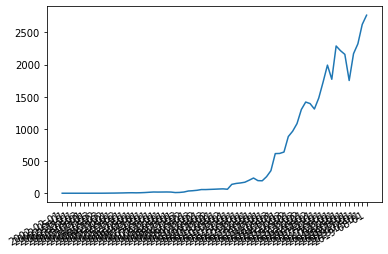

In [162]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['total'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

In [163]:
cagrs = df_account['cagr']
rolling_cagrs = []
ROLLING = 3
for i in range(len(cagrs)):
    if i - 3 < 0:
        rolling_cagr = np.mean(cagrs[0:i])
    else:
        rolling_cagr = np.mean(cagrs[i - 3:i])
    rolling_cagrs.append(rolling_cagr)

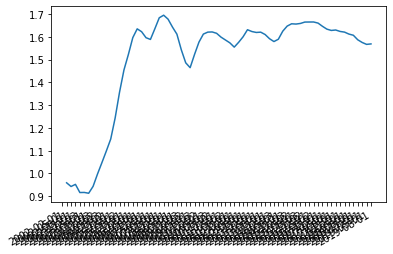

In [164]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], rolling_cagrs, marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

In [165]:
# 가격 정보가 없는 경우 상폐로 처리했음. 실제로 상폐까지는 아니고 거래정지인 경우가 있음
delisted_stocks = sum(df_account['delisted'])

In [166]:
cagr = pow(df_account['total'][len(df_account) - 1], 1/(len(df_account)/REBALANCE))

In [167]:
# MDD, MDD duration 구하기
max_yield = -100.0
min_yield = 0.0
mdd = 0.0
mdd_duration = 0 

dd = 0.0
dd_duration = 0
for val in df_account['total']:
    if val > max_yield:
        max_yield = val
        min_yield = val
        dd_duration = 0
        continue
    
    if val < min_yield:
        min_yield = val
        dd = (1.0 - min_yield / max_yield) * 100.0
        dd_duration += 1
        
        if dd > mdd:
            mdd = dd
        if dd_duration > mdd_duration:
            mdd_duration = dd_duration
            
if REBALANCE == 2:
    mdd_duration *= 6
elif REBALANCE == 4:
    mdd_duration *= 3

In [168]:
# 수익률 표준편차 구하기
filetered_yield = list(df_account['yield']).copy()

# outlier 제거
filetered_yield.remove(max(filetered_yield))
filetered_yield.remove(min(filetered_yield))

std_yield = statistics.stdev(filetered_yield)

In [169]:
# 평균 승률 
yields = []
for i in range(len(df_account)):
    yields.extend(df_account.iloc[i]['yields'])
    
win_rate = (sum([val > 1.0 for val in yields]) / len(yields)) * 100.0

In [170]:
t = PrettyTable(['Rebalance', 'CAGR', 'MDD', 'MDD duration', 'STD', 'Delisted', 'Win rate', 'Note'])
t.add_row([os.path.basename(DATA_DIR),
           "%.2f%%" % ((cagr - 1.0) * 100.0),
           "%.2f%%" % (mdd),
           mdd_duration,
           "%.4f" % std_yield,
           delisted_stocks,
           "%.2f%%" % win_rate,
           ""
          ])
print(t)

+-----------+--------+--------+--------------+--------+----------+----------+------+
| Rebalance |  CAGR  |  MDD   | MDD duration |  STD   | Delisted | Win rate | Note |
+-----------+--------+--------+--------------+--------+----------+----------+------+
|  2-5-8-11 | 56.28% | 43.58% |      9       | 0.1936 |    54    |  55.16%  |      |
+-----------+--------+--------+--------------+--------+----------+----------+------+


In [171]:
# 수수료 고려
df_account['fee_yield'] = df_account['yield'] * 0.99
df_account['fee_total'] = df_account['fee_yield'].cumprod()
pow(df_account['fee_total'][len(df_account) - 1], 1/(len(df_account)/REBALANCE))

1.5012261071010944